[View in Colaboratory](https://colab.research.google.com/github/simpsonchristo/MLword2vec/blob/master/word2vecBasicTutorial.ipynb)

# word2vec Basic Tutorial

This tutorial uses the basic word2vec code available from [word2vec_basic.py](https://github.com/tensorflow/tensorflow/blob/r1.8/tensorflow/examples/tutorials/word2vec/word2vec_basic.py)
This is the skip-gram implementation of word2vec. See the TensorFlow [tutorial](https://www.tensorflow.org/tutorials/word2vec) for more details.

## Data Preparation
Download the data and prepare it in a dictionary. The dictionary relates the strings to the integers.

In [0]:
# Copyright 2015 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Basic word2vec example."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import sys
import argparse
import random
from tempfile import gettempdir
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

from tensorflow.contrib.tensorboard.plugins import projector

In [0]:
# Give a folder path as an argument with '--log_dir' to save
# TensorBoard summaries. Default is a log folder in current directory.
current_path = os.path.dirname(os.path.realpath(sys.argv[0]))

parser = argparse.ArgumentParser()
parser.add_argument(
    '--log_dir',
    type=str,
    default=os.path.join(current_path, 'log'),
    help='The log directory for TensorBoard summaries.')
FLAGS, unparsed = parser.parse_known_args()

# Create the directory for TensorBoard variables if there is not.
if not os.path.exists(FLAGS.log_dir):
  os.makedirs(FLAGS.log_dir)

In [0]:
#Download the data
url = 'http://www.mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present. Make sure it's the right size."""
  local_filename = filename #os.path.join(gettempdir(), filename)
  if not os.path.exists(local_filename):
    local_filename,_ = urllib.request.urlretrieve(url + filename,
                                                  local_filename)
    
  statinfo = os.stat(local_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    print(statinfo.st_size)
    raise Exception('Failed to verify' +  local_filename + 
                    '. Can you get to it with a browser?')
  return local_filename

In [0]:
#Read the data into a list of strings
def read_data(filename):
  """Extract from a zip file and read a list of words from the extracted file"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  
  return data

In [5]:
#Download file, read file, and check size
filename = maybe_download('text8.zip', 31344016)
vocabulary = read_data(filename)
print('Data size', len(vocabulary))
print('The first element of vocabulary is ' + vocabulary[0])

Found and verified text8.zip
Data size 17005207
The first element of vocabulary is anarchism


In [0]:
#Replace rare words with UNK token and build dictionary
# data               - list of codes (integers from 0 to vocabulary_size - 1)
#                    - Original text replaced by their codes
# count              - map of strings (words) to count occurences
# dicitionary        - map of strings (words) to their codes(integers)
# reverse_dictionary - map of codes (integers) to their strings(words)

vocabulary_size = 50000
def build_dataset(words, n_words):
  """Process raw inputs into a dataset."""
  count = [['UNK',-1]]
  count.extend(collections.Counter(words).most_common(n_words-1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  
  data = list()
  unk_count = 0
  for word in words:
    index = dictionary.get(word,0)
    if index == 0: #dictionary ['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reversed_dictionary

In [7]:
#Filling 4 global variables
data, count, dictionary, reverse_dictionary = build_dataset(vocabulary,
                                                             vocabulary_size)
#reduce_memory
del vocabulary
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

data_index = 0

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


## Training Data
Prepare part of the data for a training set. 

In [0]:
# batch_size     - size of the batch
# embedding_size - dimension of the embedding vector
# skip_window    - how many words to consider left and right
#                - "red" fox "jumped"
# num_skips      - how many times to reuse an input to generate a label
# num_sampled    - number of negative examples to sample


def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype = np.int32)
  span = 2 * skip_window + 1 # [skip_window target skip_window]
  buffer = collections.deque(maxlen=span) #pylint: disable = redefined-builtin
  if data_index + span > len(data):
    data_index = 0
  buffer.extend(data[data_index:data_index + span])
  data_index += span
  for i in range(batch_size // num_skips):
    context_word = [w for w in range(span) if w != skip_window]
    words_to_use = random.sample(context_word, num_skips)
    for j, context_word in enumerate(words_to_use):
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[context_word]
    if data_index == len(data):
      buffer.extend(data[0:span])
      data_index = span
    else:
      buffer.append(data[data_index])
      data_index += 1
    
  data_index = (data_index + len(data) - span) % len(data)
  return batch, labels

#batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
#for i in range(8):
#  print(batch[i], reverse_dictionary[batch[i]], 
#      '->', labels[i,0], reverse_dictionary[labels[i,0]])


## Build and train skip-gram model

We pick a random validation set to sample nearest neighbors. Here we limit the validation samples to the words that have a low numeric ID, which by construction are also the most frequent.  ```valid_size, valid_window, valid_examples``` are used only for displaying model accuracy. They do not affect calculation. ```valid_size``` is a random set of words to evaluate similarity on. ```valid_window``` picks dev samples in the head of the distribution. ```valid_examples``` uses these values to pick the validation examples. 



In [0]:
#training data
batch_size = 128
embedding_size = batch_size
skip_window = 2
num_skips = 4
num_sampled = batch_size/2
learning_rate = 1.0

#validation data
valid_size = 16
valid_window = 100
valid_examples = np.random.choice(valid_window, valid_size, replace = False)

In [0]:
#graph to display results
graph = tf.Graph()
with graph.as_default():

  with tf.name_scope('inputs'):
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size,1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
  #ops and variables pinned to CPU if GPU implementation mission
  #with tf.device('/cpu:0'):
  ##look up embeddings for inputs
  with tf.name_scope('embeddings'):
    embeddings = tf.Variable( tf.random_uniform([vocabulary_size, 
                                                 embedding_size],
                                                -1.0,
                                                 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)
    
  #construct variables for NCE loss
  with tf.name_scope('weights'):
    nce_weights = tf.Variable( 
        tf.truncated_normal([vocabulary_size,
                             embedding_size],
                            stddev=1.0/math.sqrt(embedding_size)))
  with tf.name_scope('bias'):
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  #compute the average nce loss
  # tf.nce_loss draws a new sample of the negative labels each time we evaluate
  # the loss. 
  
  with tf.name_scope('loss'):
    loss = tf.reduce_mean( tf.nn.nce_loss(weights = nce_weights,
                                          biases = nce_biases,
                                          labels = train_labels,
                                          inputs = embed,
                                          num_sampled = num_sampled,
                                          num_classes = vocabulary_size))
  #add the loss value as a scalar to summary
  tf.summary.scalar('loss', loss)
  
  #construct the SGD optimizer
  with tf.name_scope('optimizer'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
  
  #compute cosine similarity between minibatch examples and all embeddings
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings/norm
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,
                                            valid_dataset)
  
  similarity = tf.matmul(valid_embeddings, 
                         normalized_embeddings,
                         transpose_b = True)
  #Merge all summaries
  merged = tf.summary.merge_all()
  #initialize all variables
  init = tf.global_variables_initializer()
  #create a saver
  saver = tf.train.Saver()

### Begin Training

In [14]:
num_steps = 100001
with tf.Session(graph=graph) as session:
  #write summaries
  writer = tf.summary.FileWriter(FLAGS.log_dir, session.graph)
  #initialize all variables
  init.run()
  print('Initialized')
  
  average_loss = 0
  for step in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(batch_size,
                                                num_skips,
                                                skip_window)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
    #MetaData variable
    run_metadata = tf.RunMetadata()
    
    
    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    # Also, evaluate the merged op to get all summaries from the returned "summary" variable.
    # Feed metadata variable to session for visualizing the graph in TensorBoard.
    _, summary, loss_val = session.run(
        [optimizer, merged, loss],
        feed_dict=feed_dict,
        run_metadata=run_metadata)
    average_loss += loss_val

    # Add returned summaries to writer in each step.
    writer.add_summary(summary, step)
    # Add metadata to visualize the graph for the last run.
    if step == (num_steps - 1):
      writer.add_run_metadata(run_metadata, 'step%d' % step)

    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step ', step, ': ', average_loss)
      average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8  # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        log_str = 'Nearest to %s:' % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log_str = '%s %s,' % (log_str, close_word)
    print(log_str)
    
  final_embeddings = normalized_embeddings.eval()

  # Write corresponding labels for the embeddings.
  with open(FLAGS.log_dir + '/metadata.tsv', 'w') as f:
    for i in xrange(vocabulary_size):
      f.write(reverse_dictionary[i] + '\n')

  # Save the model for checkpoints.
  saver.save(session, os.path.join(FLAGS.log_dir, 'model.ckpt'))

  # Create a configuration for visualizing embeddings with the labels in TensorBoard.
  config = projector.ProjectorConfig()
  embedding_conf = config.embeddings.add()
  embedding_conf.tensor_name = embeddings.name
  embedding_conf.metadata_path = os.path.join(FLAGS.log_dir, 'metadata.tsv')
  projector.visualize_embeddings(writer, config)

writer.close()
  
    

Initialized
Average loss at step  0 :  283.8157043457031
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, mais

Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to

Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to

Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to

Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to


Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest t

Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to

Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to

Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to

Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to

Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to

Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to

Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to

Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to

Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to


Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest t

Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to

Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to


Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest t

Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to

Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to

Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to

Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to

Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to

Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to

Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to

Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to

Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to

Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to

Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to


Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest t

Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to

Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to

Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to

Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to nine: kilimanjaro, taunted, maison, aba, altos, steen, turkmenistan, radiance,
Nearest to

Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine:


Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine

Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine:

Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine:

Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine:

Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine:

Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine:


Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine

Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine:

Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine:

Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine:

Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine:

Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine:

Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine:

Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine:

Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine:

Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine:

Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine:

Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine:

Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine:


Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine

Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine:

Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine:

Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine:

Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine:

Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine:

Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine:

Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine:

Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine:

Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine:

Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine: one, zero, gland, hinder, approximation, verse, two, pseudocode,
Nearest to nine:

Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three

Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three

Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three

Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three

Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three

Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three

Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three

Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three

Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three

Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three

Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three

Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three

Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three


Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, thre

Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three

Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three

Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three

Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three

Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three

Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three

Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three

Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three


Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, thre

Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three


Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, thre

Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three

Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three

Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three, one, four, two, five,
Nearest to nine: eight, six, zero, three

Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to

Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to

Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to

Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to

Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to

Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to

Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to

Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to

Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to

Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to

Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to

Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to

Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to


Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest t

Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to

Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to

Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to

Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to

Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to

Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to

Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to

Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to

Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to

Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to

Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to

Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to


Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest t

Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to

Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to nine: eight, seven, three, five, six, four, one, zero,
Nearest to

Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to


Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest t

Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to

Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to

Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to

Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to

Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to

Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to

Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to

Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to

Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to

Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to

Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to

Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to

Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to

Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to

Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to

Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to


Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest t

Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to

Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to

Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to

Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to

Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to

Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to

Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to

Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to

Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to


Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest t

Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to

Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to

Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to

Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to

Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to

Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to

Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to

Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to

Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to

Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to


Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest t

Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to

Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to


Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest t

Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to

Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to

Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to

Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to


Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest t

Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to

Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to


Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest t

Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to

Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to

Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to

Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to

Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to

Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to nine: eight, seven, three, five, six, two, zero, four,
Nearest to


Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest t

Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to

Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to

Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to

Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to

Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to

Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to

Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to

Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to

Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to

Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to

Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to

Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to

Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to

Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to

Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to

Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to

Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to

Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to

Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to

Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to

Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to

Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to


Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest t

Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to

Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to

Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to

Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to nine: eight, seven, six, four, zero, five, three, one,
Nearest to

Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, s


Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, 

Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, s

Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, s

Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, s

Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, s

Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, s

Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, s

Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, s

Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, s

Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, s


Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, 

Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, s

Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, s

Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, s

Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, s


Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, 

Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, s

Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, s

Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, s

Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, s


Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, 

Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, s

Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, s

Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, s

Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, s


Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, seven, six, four, five, three, two, one,
Nearest to nine: eight, 

Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to

Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to

Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to

Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to

Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to

Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to

Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to

Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to

Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to

Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to

Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to

Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to

Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to

Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to

Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to


Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest t

Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to

Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Average loss at step  86000 :  5.147895086288452
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, sev

Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to

Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to

Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to

Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to


Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest t

Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to

Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to

Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to

Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to

Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to nine: eight, seven, zero, six, four, three, five, one,
Nearest to

Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, fiv

Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, fiv

Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, fiv

Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, fiv

Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, fiv

Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, fiv

Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, fiv

Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, fiv

Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, fiv

Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, fiv

Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, fiv


Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, fi


Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, fi

Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, fiv

Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, fiv

Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, fiv

Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, fiv

Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, fiv

Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, fiv

Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, fiv

Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, fiv

Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, fiv

Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, fiv


Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, fi

Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, fiv

Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, fiv

Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, fiv

Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, fiv

Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, fiv

Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, fiv


Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, five, six, four, zero, three, albury,
Nearest to nine: eight, seven, fi

## Visualize the Embeddings
Plot the distance between the embeddings

In [0]:
#function to draw visualization of distance between embeddings
def plot_with_labels(low_dim_embs, labels, filename):
  assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(18, 18)) #in inches
  for i, label in enumerate(labels):
    x,y = low_dim_embs[i, :]
    plt.scatter(x,y)
    plt.annotate(label,
                 xy = (x,y),
                 xytext = (5,2),
                 textcoords = 'offset points',
                 ha = 'right',
                 va = 'bottom')
  plt.savefig(filename)

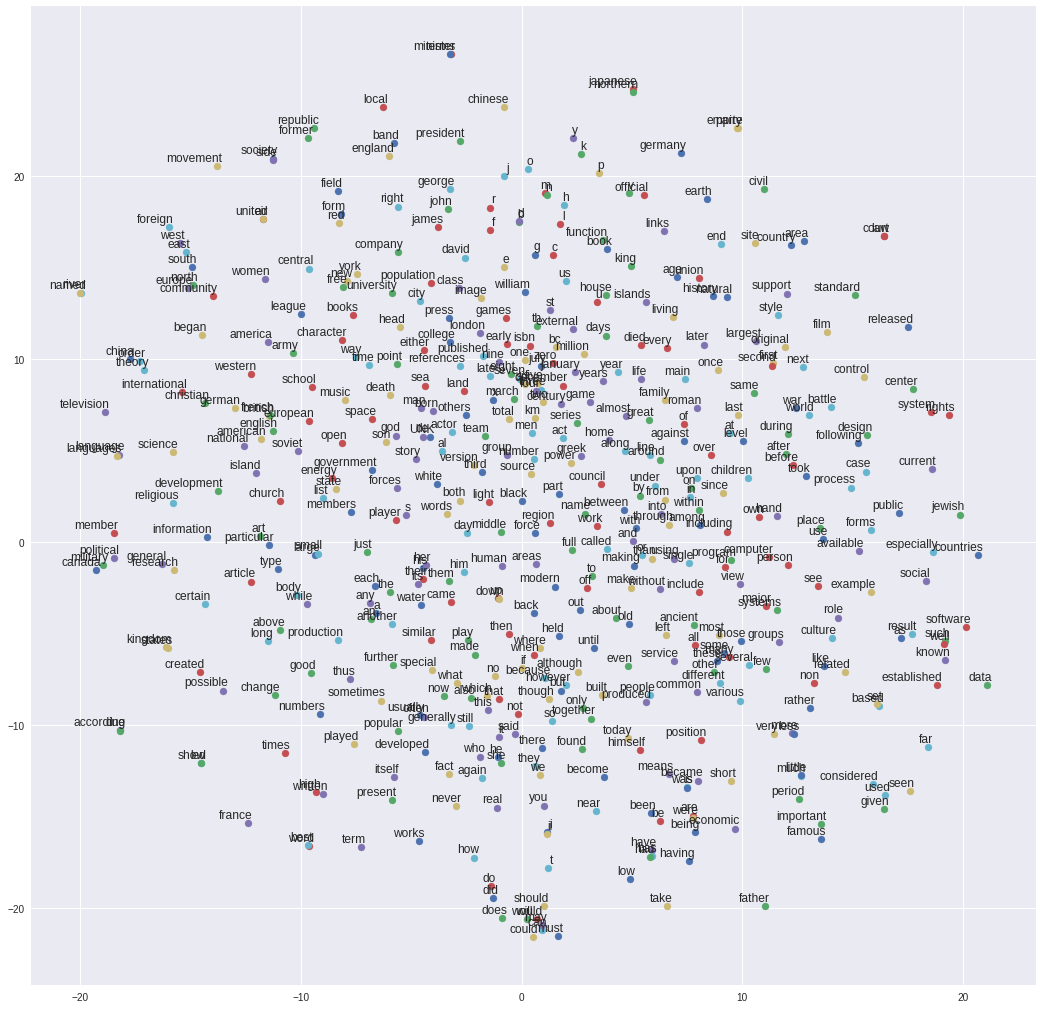

In [19]:
try:
  from sklearn.manifold import TSNE
  import matplotlib.pyplot as plt
  
  tsne = TSNE(perplexity=30,
              n_components = 2,
              init='pca',
              n_iter = 5000,
             method = 'exact')
  plot_only = 500
  low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
  labels = [reverse_dictionary[i] for i in xrange(plot_only)]
  plot_with_labels(low_dim_embs, labels, 'tsne.png') 
                                        #os.path.join(gettempdir(), 'tsne.png')

except ImportError as ex:
  print('Please install sklearn, matplotlib, and scipy to show embeddings.')
  print(ex)